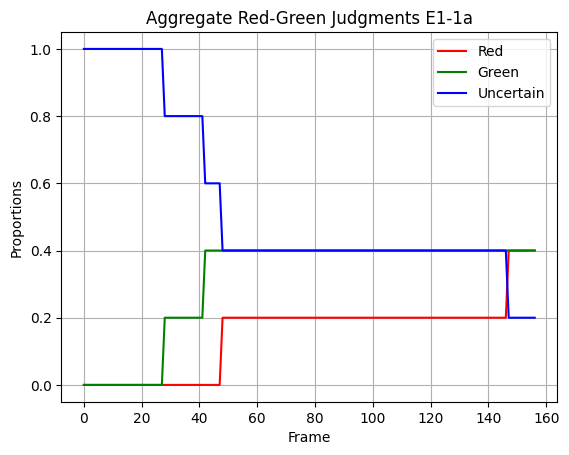

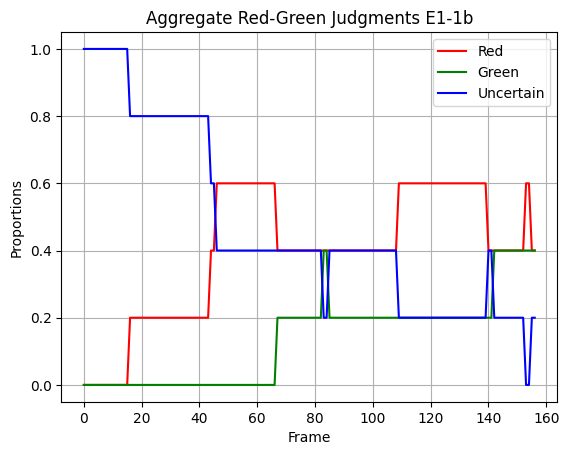

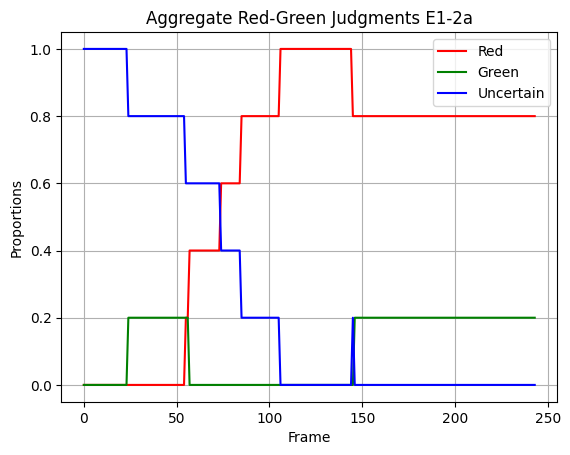

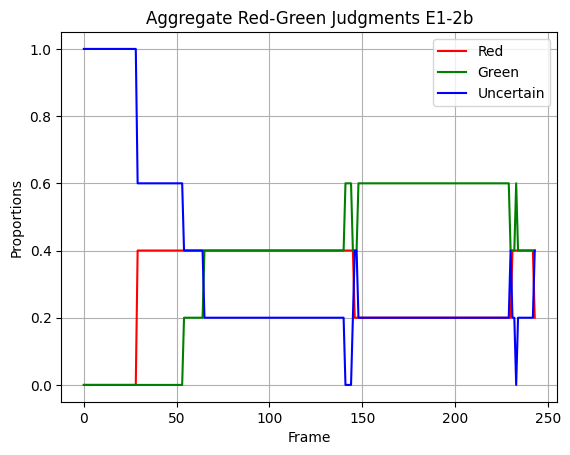

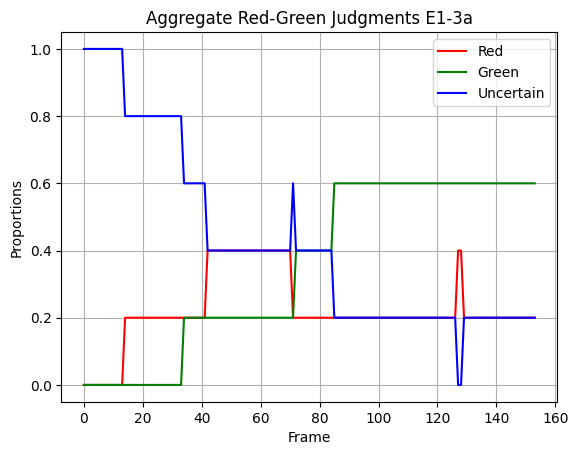

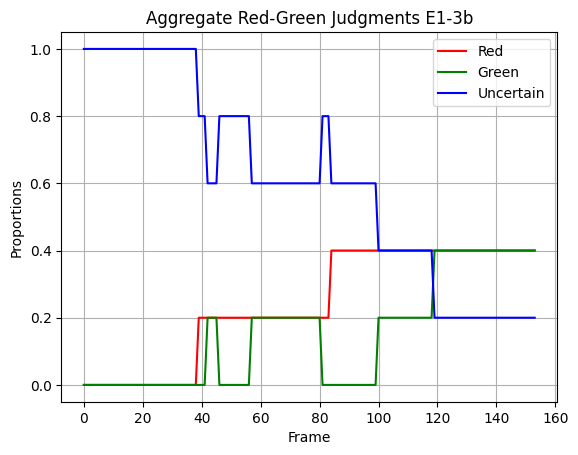

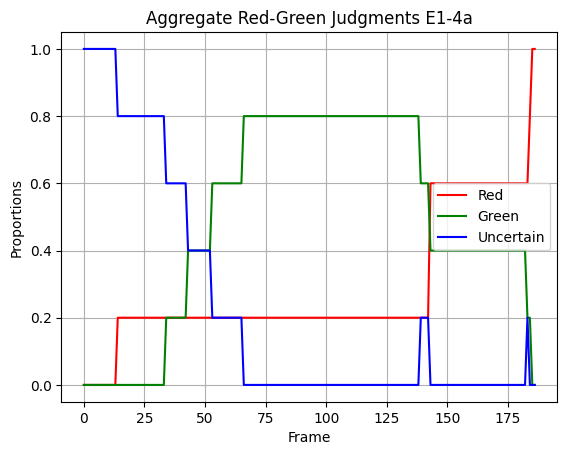

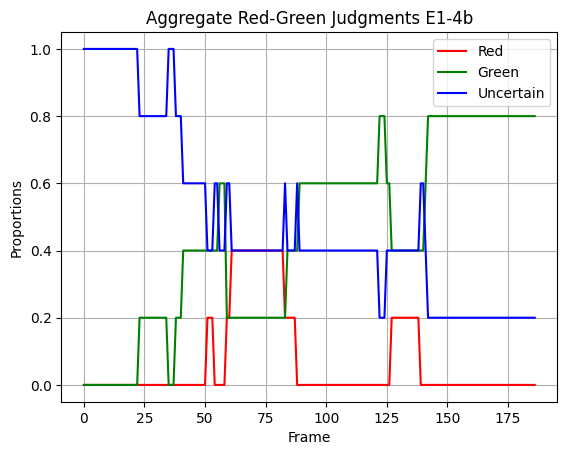

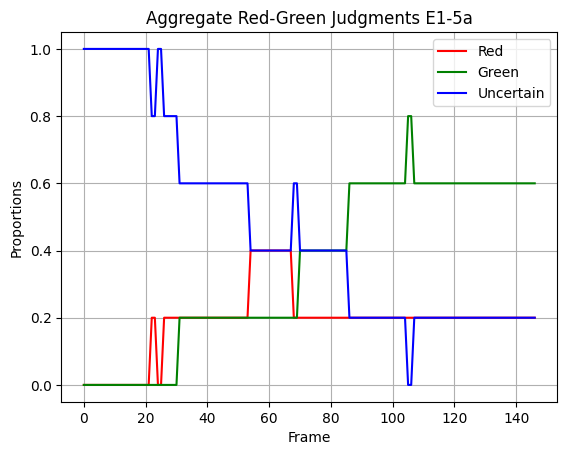

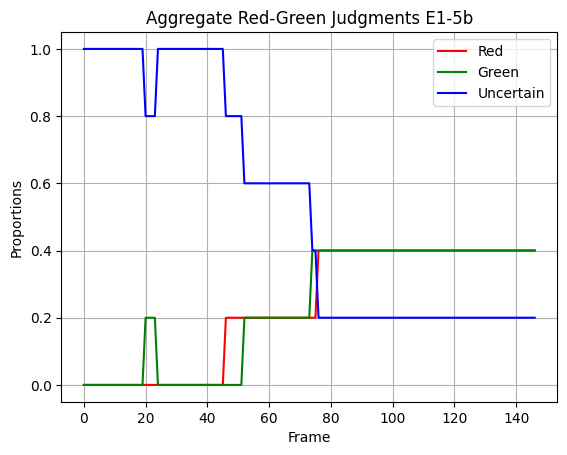

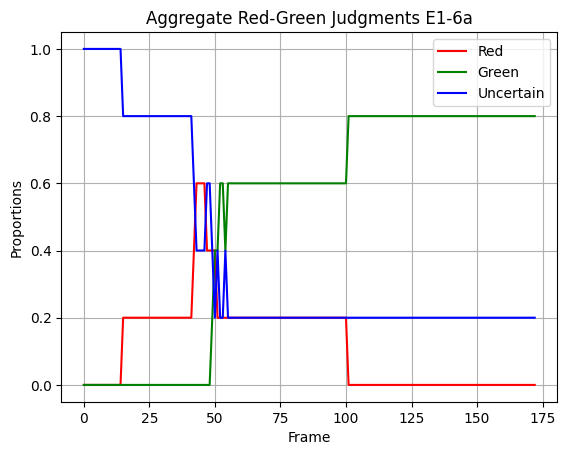

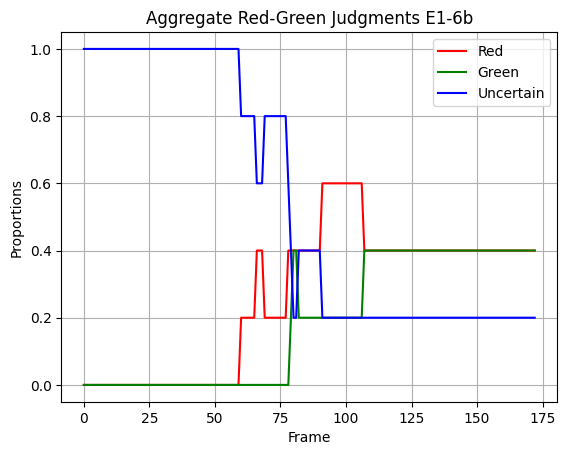

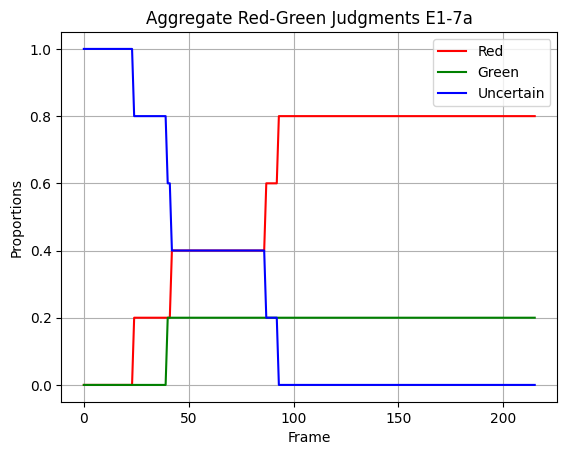

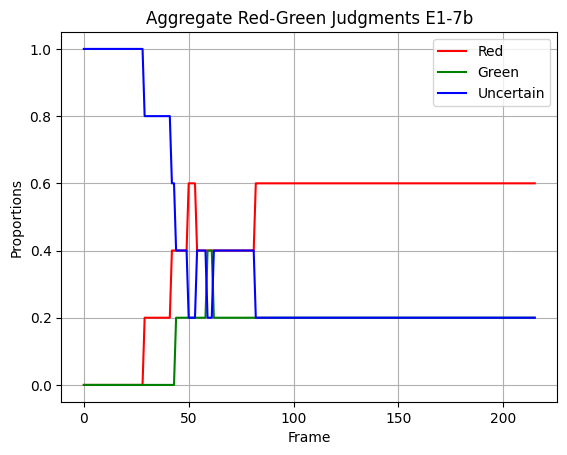

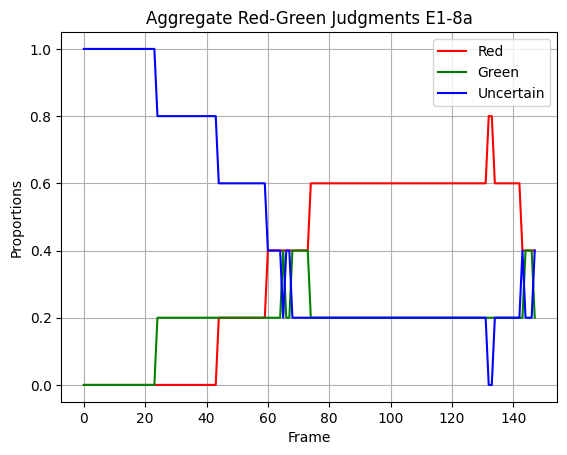

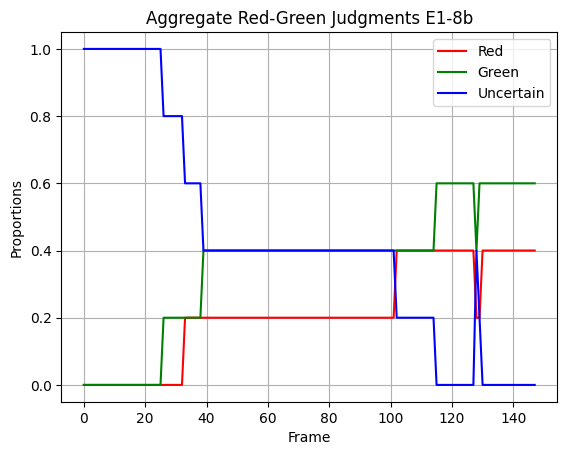

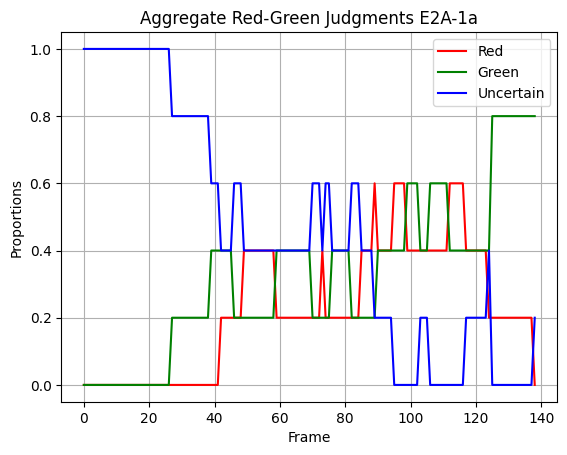

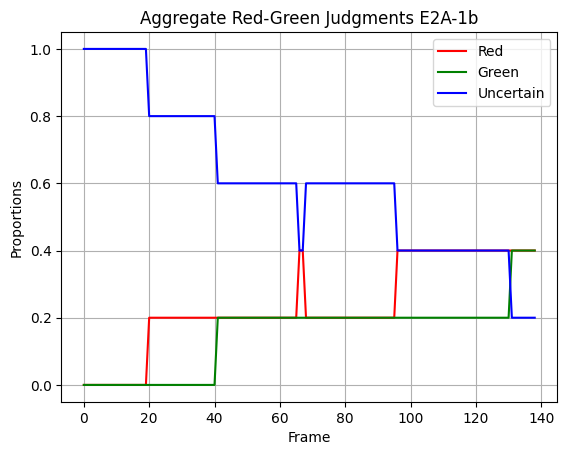

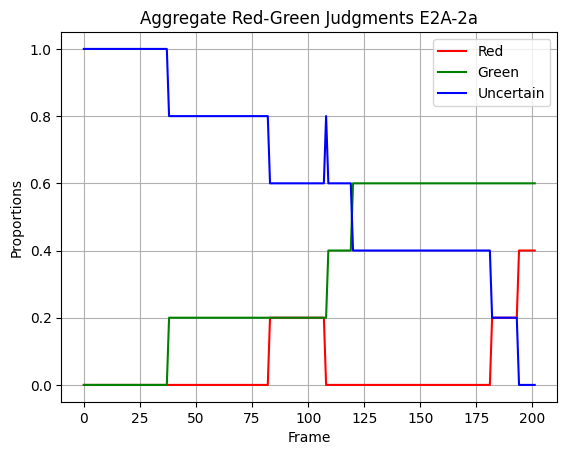

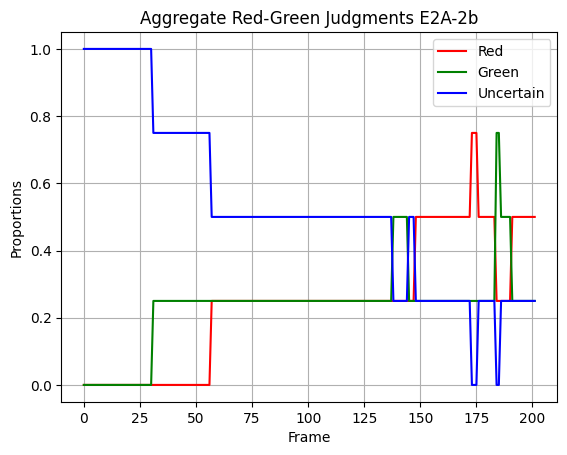

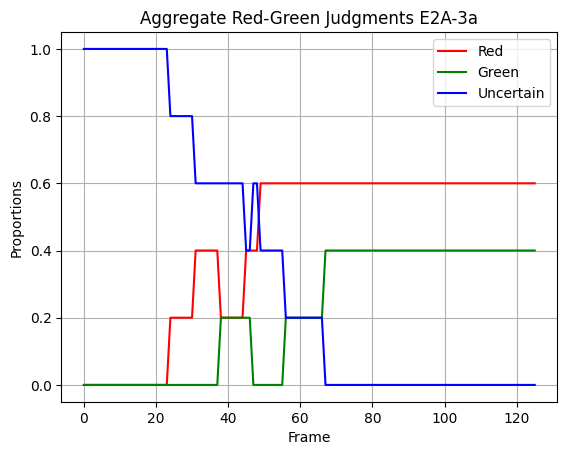

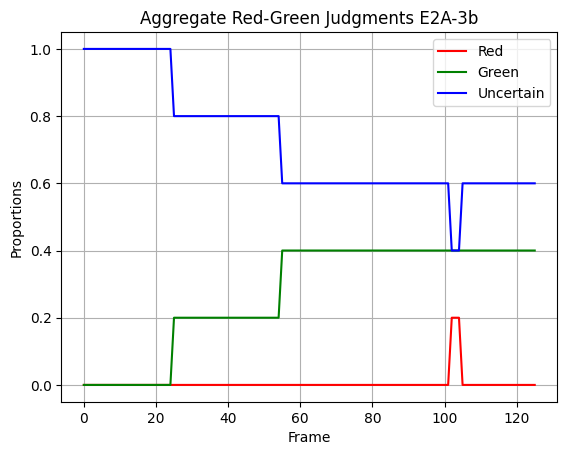

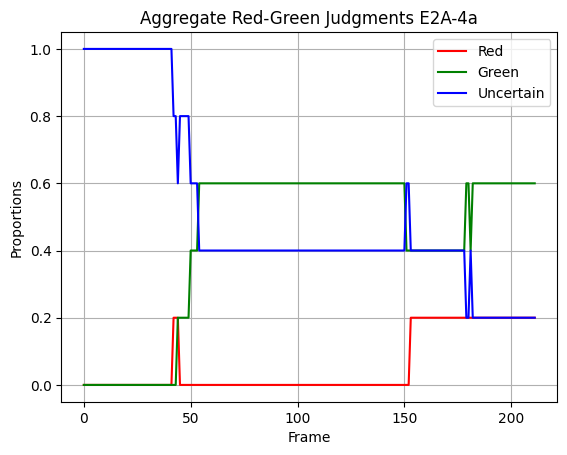

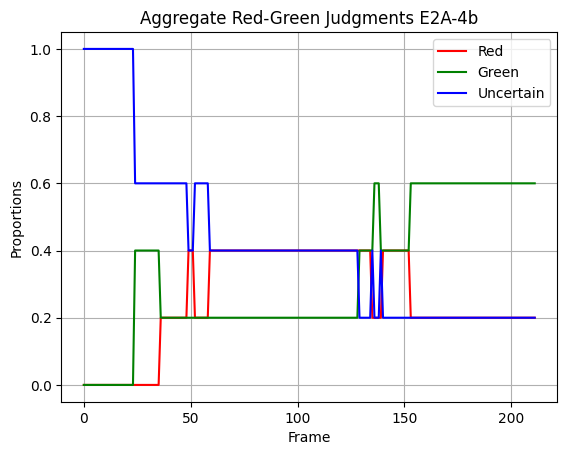

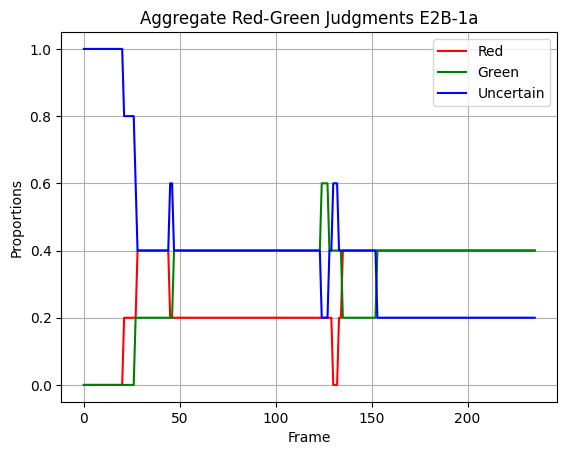

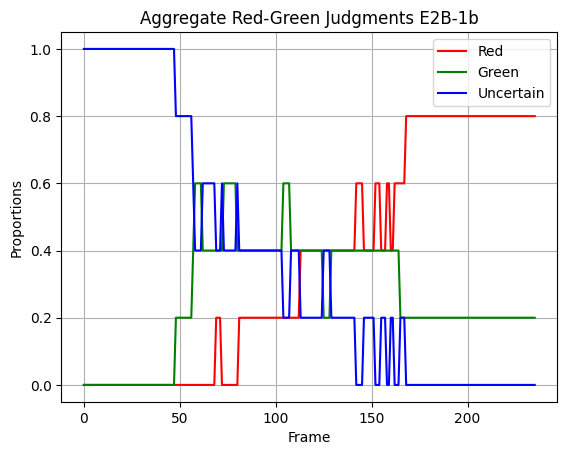

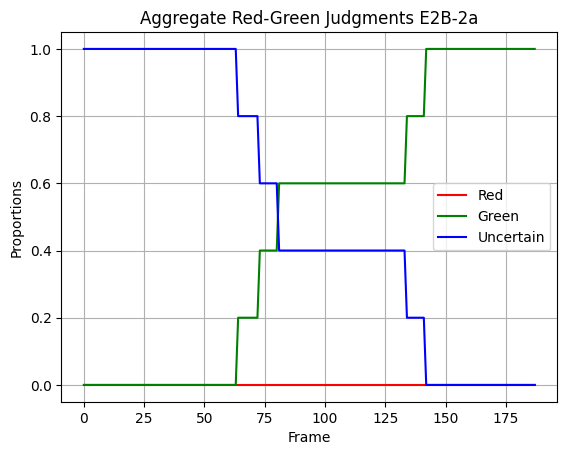

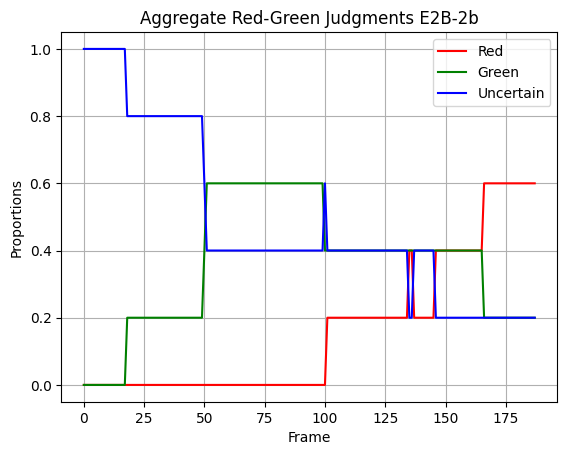

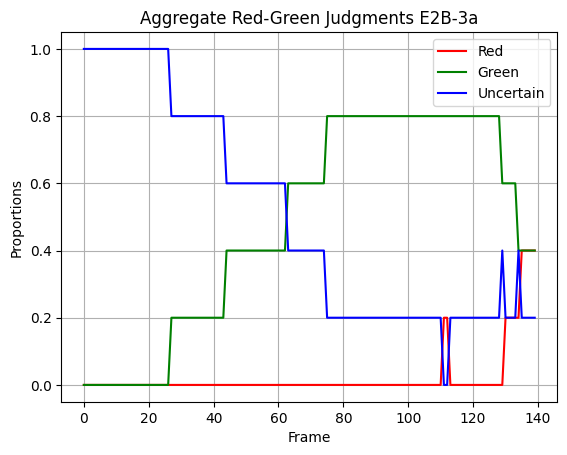

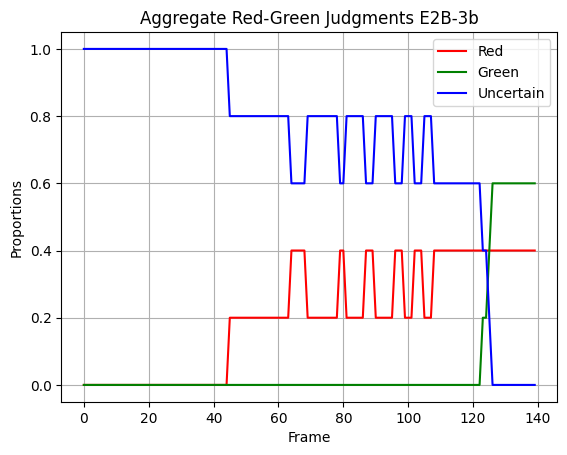

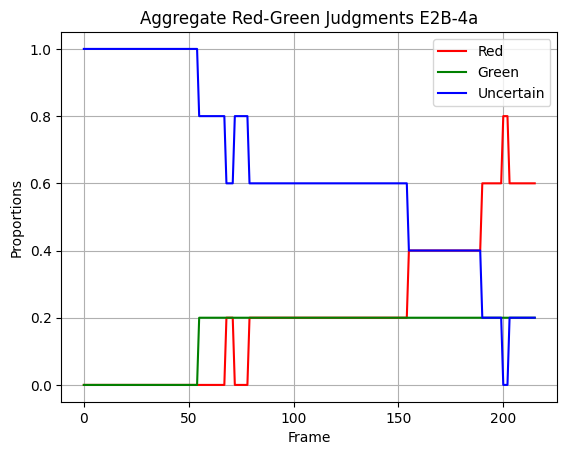

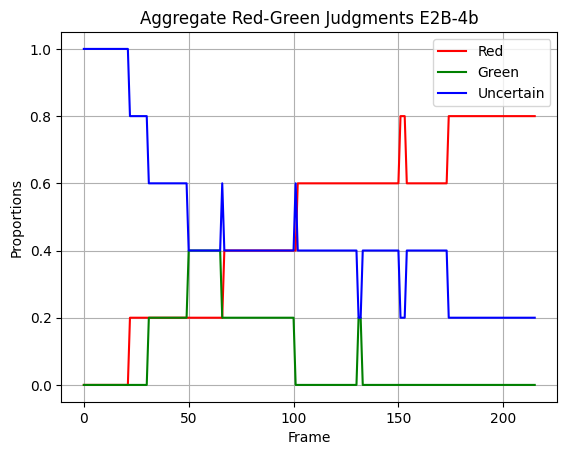

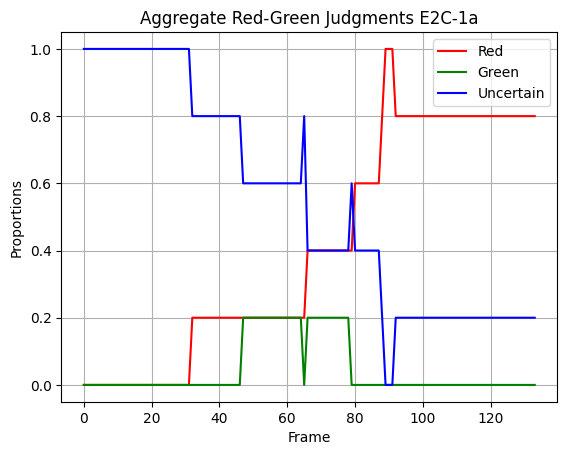

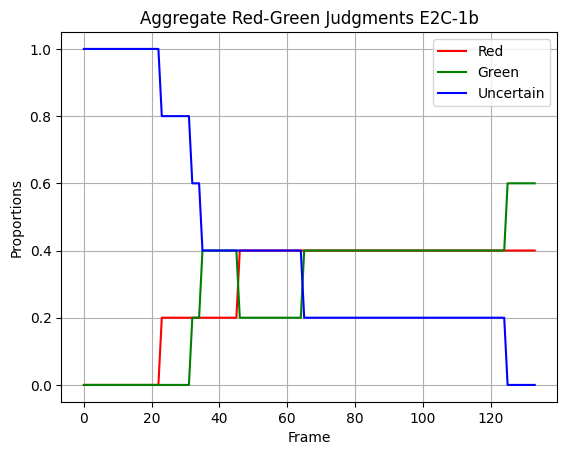

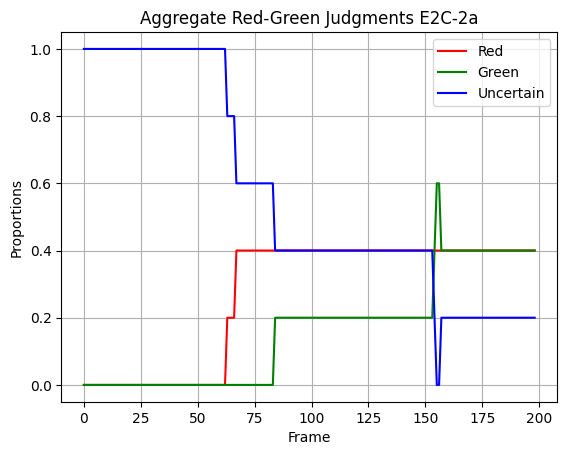

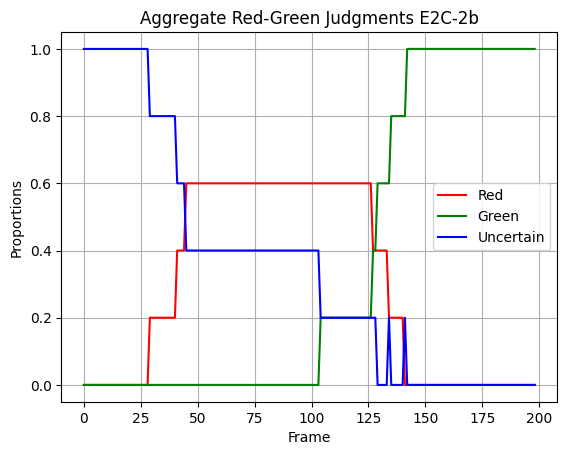

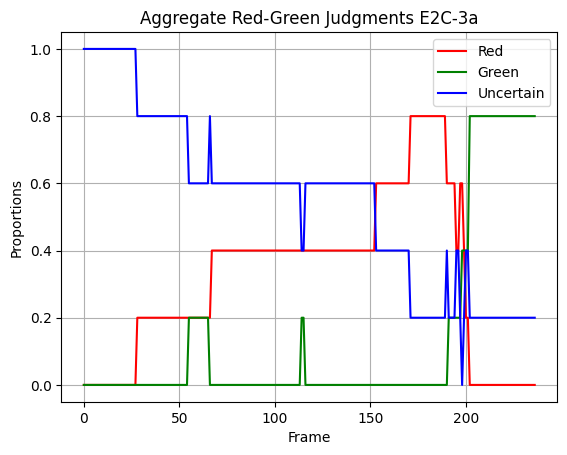

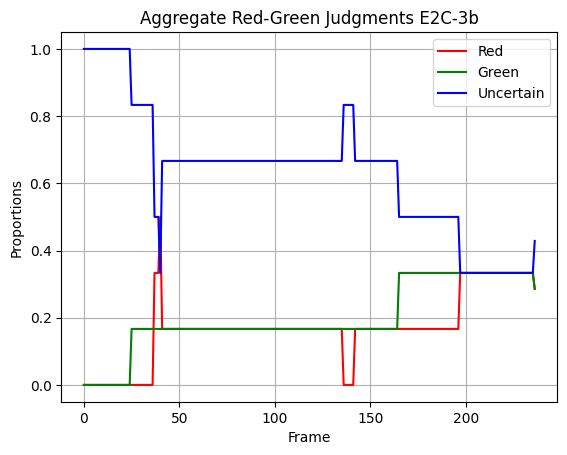

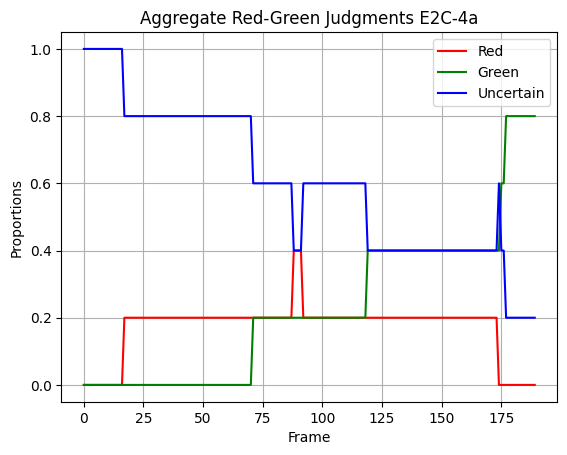

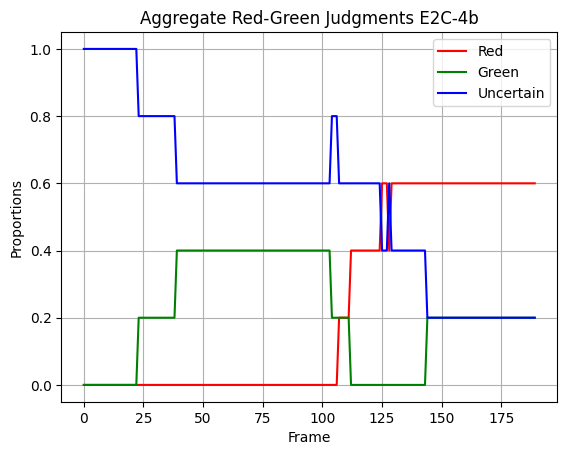

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import json

# Step 1: Connect to the database
db_path = "/Users/arijitdasgupta/Desktop/projects/red_green_site/backend/instance/pre_pilot_v0_redgreen.db"  # Update with the path to your .db file
engine = create_engine(f"sqlite:///{db_path}")  # Assuming SQLite


# Step 2: Load session data and filter for complete sessions
session_query = """
    SELECT id AS session_id, randomized_trial_order
    FROM redgreen_session
    WHERE completed = 1
"""
session_df = pd.read_sql(session_query, engine)

# Step 3: Parse randomized_trial_order and map global_trial_name
def parse_randomized_order(order_json):
    try:
        return json.loads(order_json)
    except json.JSONDecodeError:
        return []

# Add parsed randomized_trial_order to the DataFrame
session_df["parsed_order"] = session_df["randomized_trial_order"].apply(parse_randomized_order)

# Step 4: Load trial data and map `global_trial_name`
trial_query = """
    SELECT id AS trial_id, session_id, trial_index
    FROM trial
    WHERE trial_type != 'ftrial' AND completed = 1
"""
trial_df = pd.read_sql(trial_query, engine)

# Merge trials with session randomized order
merged_df = pd.merge(trial_df, session_df, left_on="session_id", right_on="session_id")

# Assign global_trial_name based on trial_index and parsed_order
def get_global_trial_name(row):
    try:
        return row["parsed_order"][row["trial_index"]]
    except IndexError:
        return None

merged_df["global_trial_name"] = merged_df.apply(get_global_trial_name, axis=1)
merged_df = merged_df.drop(columns=['randomized_trial_order'])
merged_df = merged_df.drop(columns=['parsed_order'])

# Step 5: Load keystate data and filter for valid trials
valid_trial_ids = merged_df["trial_id"].dropna().tolist()

keystate_query = f"""
    SELECT ks.frame, ks.f_pressed, ks.j_pressed, ks.trial_id
    FROM keystate ks
    WHERE ks.trial_id IN ({', '.join(map(str, valid_trial_ids))})
"""
keystate_df = pd.read_sql(keystate_query, engine)

# Merge keystate data with global_trial_name
keystate_df = pd.merge(keystate_df, merged_df[["trial_id", "global_trial_name"]], on="trial_id")

# Step 6: Process the data
# Convert boolean to integer for aggregation
keystate_df["f_pressed"] = keystate_df["f_pressed"].astype(int)
keystate_df["j_pressed"] = keystate_df["j_pressed"].astype(int)

keystate_df["red"] = ((keystate_df["f_pressed"] == 1) & (keystate_df["j_pressed"] == 0)).astype(int)
keystate_df["green"] = ((keystate_df["j_pressed"] == 1) & (keystate_df["f_pressed"] == 0)).astype(int)
keystate_df["uncertain"] = ((keystate_df["red"] == 0) & (keystate_df["green"] == 0)).astype(int)


# Group by global_trial_name and frame, calculate mean
aggregated_df = (
    keystate_df.groupby(["global_trial_name", "frame"])
    .mean(numeric_only=True)
    .reset_index()
)

# # Step 7: Plot the data
for trial_name in aggregated_df["global_trial_name"].unique():
    trial_data = aggregated_df[aggregated_df["global_trial_name"] == trial_name]
    
    plt.figure()
    plt.plot(trial_data["frame"], trial_data["red"], label="Red", color="red")
    plt.plot(trial_data["frame"], trial_data["green"], label="Green", color="green")
    plt.plot(trial_data["frame"], trial_data["uncertain"], label="Uncertain", color="blue")
    plt.title(f"Aggregate Red-Green Judgments {trial_name}")
    plt.xlabel("Frame")
    plt.ylabel("Proportions")
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
keystate_df

,frame,f_pressed,j_pressed,trial_id,global_trial_name,red,green,uncertain
0,0,0,0,12,E1-6b,0,0,1
1,1,0,0,12,E1-6b,0,0,1
2,2,0,0,12,E1-6b,0,0,1
3,3,0,0,12,E1-6b,0,0,1
4,4,0,0,12,E1-6b,0,0,1
...,...,...,...,...,...,...,...,...
36481,134,0,1,300,E2A-1a,0,1,0
36482,135,0,1,300,E2A-1a,0,1,0
36483,136,0,1,300,E2A-1a,0,1,0
36484,137,0,1,300,E2A-1a,0,1,0


In [31]:
len(aggregated_df["global_trial_name"].unique())

40